# MovieLens Recommendation System

# Contents

### 1. [Overview](#overview)
### 2. [Business and Data Understanding](#bidness)
### 3. [Data Preparation](#dataprep)
### 4. [Modeling](#modeling)
####     4.1 [Using Surprise](#surprise)
####     4.2 [Baseline Models](#baseline)
####     4.3 [Initial SVD Models](#svd)
####     4.4 [SVD Gridsearch](#grid)
####     4.5 [Non-negative Matrix Function](#nnmf)
####     4.6 [SVD++](#svd++)
### 5. [Final Model Evaluation](#final)
####     5.1 [Recommendation Function](#rec)
####     5.2 [Content-based Filtering](#content)
### 6. [Summary](#summary)

![covers](images/movie_covers.jpg)

<a id='overview'></a>

# Overview

Using the __["small" dataset](https://grouplens.org/datasets/movielens/latest/)__ from __[MovieLens](https://movielens.org/)__, which contains explicit user ratings, movie titles, genres, etc., we were able to produce a model-based collaborative filtering recommendation system that allows for user input and will return the top 5 recommendations of movies from the dataset that the use has not yet rated.  Our process involved using the Surprise Python scikit library to process data and iterate through multiple recommender algorithms (including SVD and SVD++), using GridSearch, cross-validation and RMSE to decide on our best-performing model.  Our final model used a tuned SVD algorithm with an RMSE of 0.8457.  We also created a content-based filtering model, using TF-IDF Vectorizer and cosine similarity, to address the "cold start" problem inherent in collaborative filtering models.  With this model, a user who is not already in the dataset can input a known movie from the dataset and be returned 5 movie recommendations to choose from.

<a id='bidness'></a>

# Business and Data Understanding

![just_watch](images/just_watch_logo_resize.png)

We will present to the __[JustWatch](https://www.justwatch.com/)__ streaming guide app, with the premise that they can provide movie recommendations to customers who already use their service to search across streaming platforms for a specific movie and create watchlists.  

The MovieLens small dataset contains 100,836 user ratings from 610 different users, each of whom contributed at least 20 ratings.  A total of 9,742 movie titles are included in this dataset.  There are two additional .csv files contained within the package download that we did not end up using.  One file contained 3,683 tags ("a single word or short phrase") that users applied with their numerical rating, which represented less than 4% of the total ratings in the dataset.  The other file contained links of each movie in the dataset to its listing on __[The Movie Database](https://www.themoviedb.org/)__ or on the __[Internet Movie Database](https://www.imdb.com/)__

The MovieLens dataset was specifically developed with recommendation system building in mind.  The data contains explicit user ratings, movie titles, and genres with consistent user ID and movie ID indices across files.  The business problem we were tasked with was to "build a model that provides top 5 movie recommendations to a user, based on their ratings of other movies".  Though movie recommendation systems are now common-place in the streaming apps we have available, understanding the architecture of these everyday models may allow us to expand their use into other realms, or at least refine what a model can currently provide, with the goal of delivering the most refined experience to an individual user.  

Citation included in the README.txt:  
F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>

Additional citations at end of notebook.

<a id='dataprep'></a>

# Data Preparation 

Below we will start with the necessary imports for this Jupyter Notebook, load in the data (with brief explanations for each file), and create a combined dataframe for later modeling.  

## Imports

In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly, NormalPredictor 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Loading in data files

Again, data was downloaded from the __["small" dataset](https://grouplens.org/datasets/movielens/latest/)__ from __[MovieLens](https://movielens.org/)__

### User IDs and Explicit Ratings

- minimum of 20 ratings per user ID
- total of 610 users included, selected for inclusion at random per MovieLens
- user id is the same with the tags.csv below as well
- ratings are made on a 5 star scale, with half-star increments (0.5 - 5.0)

In [3]:
ratings = pd.read_csv('data/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
# no nulls

ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [6]:
ratings['userId'].nunique()

610

### Movie IDs (including Title and Genres)

- Only movies with at least one rating or tag are included, per MovieLens
- There are 9,742 different movies included in this "small" dataset
- Movie IDs are consistent across all four data files, and correspond with the __[MovieLens.org/movies/](https://movielens.org/movies/)__ URL
- Genres are a pipe-separated list selected from the following:
    - Action
    - Adventure
    - Animation
    - Children's
    - Comedy
    - Crime
    - Documentary
    - Drama
    - Fantasy
    - Film-Noir
    - Horror
    - Musical
    - Mystery
    - Romance
    - Sci-Fi
    - Thriller
    - War
    - Western
    - (no genres listed)

In [7]:
movies = pd.read_csv('data/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [9]:
# no nulls

movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [10]:
movies['movieId'].nunique()

9742

### Links from MovieLens to IMDB and TMDB

- for IMDB complete URL: https://www.imdb.com/tt then 'movieId'
- for TMDB complete URL: https://www.themoviedb.org/movie/ then 'movieId'
- we did not utilize these links in our modeling

In [11]:
links = pd.read_csv('data/links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [12]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [13]:
# 8 nulls for TMDB

links.isna().sum()

movieId    0
imdbId     0
tmdbId     8
dtype: int64

### Tags provided by user

- Tags are "user-generated metadata about movies...typically a single word or short phrase"
- Timestamp represents seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970
- Only 3,683 tags (< 4% of total user ratings) were contained in this file, and we did not include this file in our modeling

In [14]:
tags = pd.read_csv('data/tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [15]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [16]:
# no nulls

tags.isna().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

## Combined dataframe with movies and user ratings

In [17]:
# combined on 'movieId'

df = pd.merge(movies, ratings, on='movieId')
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [18]:
df.shape

(100836, 6)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   title      100836 non-null  object 
 2   genres     100836 non-null  object 
 3   userId     100836 non-null  int64  
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


In [20]:
# verifying no nulls

df.isna().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [21]:
df.describe()

# of note, the mean for rating is 3.50.  Otherwise, numerical summaries are not relevant

,movieId,userId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,19435.295718,326.127564,3.501557,1.205946e+09
std,35530.987199,182.618491,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,1199.000000,177.000000,3.000000,1.019124e+09
50%,2991.000000,325.000000,3.500000,1.186087e+09
75%,8122.000000,477.000000,4.000000,1.435994e+09
max,193609.000000,610.000000,5.000000,1.537799e+09


<a id='modeling'></a>

# Modeling

We will start by using the Suprise Python scikit library for processing and preparing our data for the eventual recommendation system.  We will create a baseline random model, and progress from there to using Alternating Least Squares, Singular Value Decomposition (with GridSearch cross-validation), non-negative Matrix Factorization, and SVD++ (also with GridSearch cross-validation).  The GridSearch cells will be commented out due to the length of time they take to run.  

We evaluated each algorithm iteration using root mean squared error (RMSE) from the accuracy library in Surprise.  The lowest RMSE we were able to obtain was 0.8464.  

We will discuss limitations of our model and recommendations for future development in the section where we create and utilize our recommendation system.  

<a id='surprise'></a>

## Using Surprise to perform a train/test split

In [22]:
# instantiating Reader (with 0.5 to 5 rating scale) and Dataset (from combined dataframe above)

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [23]:
# train/test split at 80/20

trainset, testset = train_test_split(data, test_size=0.2, random_state=24)

In [24]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')
print('Number of ratings: ', trainset.n_ratings, '\n')

Number of users:  610 

Number of items:  9010 

Number of ratings:  80668 



In [25]:
# confirming 80% trainset

(trainset.n_ratings) / len(df)

0.7999920663255187

<a id='baseline'></a>

## Baseline Simple Model - Random Rating

The NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal.  Unsurprisingly, this model yielded the highest RMSE.

In [47]:
# Instantiate and fit model
baseline = NormalPredictor()
baseline.fit(trainset)

# Return test predictions for model fit on trainset
predictions = baseline.test(testset)

# Save RMSE score to variable
baseline_normal = accuracy.rmse(predictions)

RMSE: 1.4327


In [48]:
cross_validate(baseline, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm NormalPredictor on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.4233  1.4249  1.4269  1.4250  0.0015  
Fit time          0.06    0.05    0.04    0.05    0.00    
Test time         0.09    0.09    0.09    0.09    0.00    


{'test_rmse': array([1.42327395, 1.42490455, 1.42686455]),
 'fit_time': (0.055826663970947266, 0.05301332473754883, 0.04456925392150879),
 'test_time': (0.09028220176696777, 0.09244060516357422, 0.0921182632446289)}

## Baseline Simple Model - Baseline Estimate

Using Alternating Least Squares.  This already drops the RMSE significantly from the random model, down to 0.8683

In [49]:
# Instantiate and fit model
baseline2 = BaselineOnly()
baseline2.fit(trainset)

# Return test predictions for model fit on trainset
predictions = baseline2.test(testset)

# Save RMSE score to variable
baseline_only = accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.8683


In [29]:
cross_validate(baseline2, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8709  0.8811  0.8798  0.8773  0.0045  
Fit time          0.04    0.05    0.04    0.04    0.00    
Test time         0.12    0.09    0.09    0.10    0.01    


{'test_rmse': array([0.87093821, 0.88108248, 0.87984931]),
 'fit_time': (0.0382227897644043, 0.04540848731994629, 0.04196786880493164),
 'test_time': (0.1170053482055664, 0.09234762191772461, 0.08936476707458496)}

<a id='svd'></a>

## Singular Value Decomposition (SVD) and Cross-validating a Simple Model 

Our first matrix factorization-based algorithm and model.  We used random_state for all algorithms from this point on, for reproducibility.  With an RMSE of 0.8698, this did not perform as well as Least Alternating Squares above (0.8683), but we will pursue tuning this algorithm. 

In [51]:
# default (Funk's) SVD, no hyperparametertuning
svd_basic = SVD(random_state=24)

# Fit to trainset and predict on the testset for evaluation
svd_basic.fit(trainset)
predictions = svd_basic.test(testset)

# Save RMSE score to variable
svd_simple = accuracy.rmse(predictions)

RMSE: 0.8698


In [53]:
cross_validate(svd_basic, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8830  0.8810  0.8774  0.8805  0.0023  
Fit time          2.64    2.57    2.62    2.61    0.03    
Test time         0.15    0.14    0.12    0.14    0.01    


{'test_rmse': array([0.88303416, 0.88095961, 0.87740483]),
 'fit_time': (2.643671989440918, 2.566042184829712, 2.6193103790283203),
 'test_time': (0.14917516708374023, 0.1415698528289795, 0.11627626419067383)}

<a id='grid'></a>

## GridSearchCV

We will now begin a GridSearch with cross-validation to try to optimize hyperparameters and find a lower RMSE, yielding the best algorithm for our recommendation system. 

The default SVD hyperparameters include: n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02 and biased=True.  Here are some brief explanations of each:
- n_factors: the number of factors considered (choosing from the user and item factors)
- n_epochs: the number of iteration of the stochastic gradient descent procedure
- lr_all: the learning rate for all parameters
- reg_all: the regularization term for all parameters
- biased: whether to use baselines (or biases)

### GridSearchCV 1

In [65]:
# dictionary of hyperparameters

"""""""""
including default n_factors, but choosing lower n_epochs
also included default lr_all, but went above and below default reg_all
default bias is True, but included possibility of False on this GridSearch only
"""""""""
svd_param_grid = {'n_factors':[20, 50, 100],
                  'n_epochs': [5, 10], 
                  'lr_all': [0.002, 0.005, 0.05],
                  'reg_all': [0.01, 0.1, 0.5],
                 'biased': [True, False]}

# instantiate GridSearch
# svd_gs_model = GridSearchCV(SVD,param_grid=svd_param_grid,measures=['rmse'],n_jobs = -2,joblib_verbose=5)

# model is fit and best_params scored by RMSE
svd_gs_model.fit(data)
svd_gs_model.best_params['rmse']

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  51 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-2)]: Done 141 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-2)]: Done 267 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-2)]: Done 429 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done 540 out of 540 | elapsed:  2.2min finished


{'n_factors': 100,
 'n_epochs': 10,
 'lr_all': 0.05,
 'reg_all': 0.1,
 'biased': True}

In [66]:
# using best params from above:
svd = SVD(n_factors=100, n_epochs=10, lr_all=0.05, reg_all=0.1, biased=True, random_state=24)

# Fit to trainset and predict on the testset for evaluation
svd.fit(trainset)
predictions = svd.test(testset)

# Save RMSE score to variable 
svd_gs1 = accuracy.rmse(predictions)

RMSE: 0.8543


The RMSE for this tuned model (0.8543) is lower than the RMSE for the default SVD (0.8698) and the baseline ALS (0.8683).  We will cross-validate and continue grid searching

In [33]:
cross_validate(svd, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8657  0.8692  0.8619  0.8656  0.0030  
Fit time          1.77    1.75    1.80    1.78    0.02    
Test time         0.29    0.30    0.29    0.29    0.00    


{'test_rmse': array([0.86566399, 0.86918133, 0.86187192]),
 'fit_time': (1.772707462310791, 1.750173807144165, 1.8028326034545898),
 'test_time': (0.2925539016723633, 0.29720425605773926, 0.29221606254577637)}

### GridSearchCV 2

In [54]:
# dictionary of hyperparameters

"""""""""
including default n_epochs, but choosing lower n_factors
also included default lr_all, but went above and below default reg_all

"""""""""

svd_param_grid = {'n_factors':[20, 30, 50],
                  'n_epochs': [10, 20, 30], 
                  'lr_all': [0.002, 0.005, 0.05],
                  'reg_all': [0.01, 0.02, 0.1]}

# instantiate GridSearch
# svd_gs2_model = GridSearchCV(SVD,param_grid=svd_param_grid,measures=['rmse'],n_jobs = -2,joblib_verbose=5)

# model is fit and best_params scored by RMSE
svd_gs2_model.fit(data)
svd_gs2_model.best_params['rmse']

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-2)]: Done 140 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-2)]: Done 266 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 405 out of 405 | elapsed:  2.9min finished


{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.05, 'reg_all': 0.1}

In [60]:
# Using best params from above
svd_2 = SVD(n_factors=50, n_epochs=30, lr_all=0.05, reg_all=0.1, random_state=24)

svd_2.fit(trainset)
predictions = svd_2.test(testset)

svd_gs2 = accuracy.rmse(predictions)

RMSE: 0.8587


The RMSE for this tuned model (0.8587) is not lower than the RMSE for the previous tuned SVD (0.8543).  We will cross-validate and continue grid searching with a different range of hyperparameters. 

In [58]:
cross_validate(svd_2, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8695  0.8627  0.8752  0.8691  0.0051  
Fit time          2.42    2.40    2.43    2.42    0.01    
Test time         0.17    0.13    0.13    0.14    0.02    


{'test_rmse': array([0.86951114, 0.86266798, 0.87521954]),
 'fit_time': (2.4202473163604736, 2.4009857177734375, 2.4348549842834473),
 'test_time': (0.1683800220489502, 0.1250011920928955, 0.12979936599731445)}

### GridSearch CV3

In [59]:
# dictionary of hyperparameters

"""""""""
including all defaults, but considering trends from prior GridSearches 
we will continue to change the ranges of our chosen hyperparameters to improve the RMSE

"""""""""

svd_param_grid = {'n_factors':[30, 60, 100],
                  'n_epochs': [20, 50, 100], 
                  'lr_all': [0.005, 0.01, 0.05],
                  'reg_all': [0.02, 0.1, 0.05]}

# instantiate GridSearch
# svd_gs3_model = GridSearchCV(SVD,param_grid=svd_param_grid,measures=['rmse'],n_jobs = -2,joblib_verbose=5)

# model is fit and best_params scored by RMSE
svd_gs3_model.fit(data)
svd_gs3_model.best_params['rmse']

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-2)]: Done 140 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done 266 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-2)]: Done 405 out of 405 | elapsed: 12.9min finished


{'n_factors': 100, 'n_epochs': 100, 'lr_all': 0.01, 'reg_all': 0.1}

In [26]:
# Using best params from above
svd_3 = SVD(n_factors=100, n_epochs=100, lr_all=.01, reg_all=0.1, random_state=24)

svd_3.fit(trainset)
predictions = svd_3.test(testset)

svd_gs3 = accuracy.rmse(predictions)

RMSE: 0.8457


In [63]:
cross_validate(svd_3, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8616  0.8572  0.8538  0.8575  0.0032  
Fit time          13.34   13.40   13.22   13.32   0.08    
Test time         0.15    0.14    0.14    0.14    0.01    


{'test_rmse': array([0.861634  , 0.85719458, 0.85379651]),
 'fit_time': (13.339827299118042, 13.398635149002075, 13.216630697250366),
 'test_time': (0.15296053886413574, 0.1384420394897461, 0.13997387886047363)}

This RMSE (0.8457) demonstrates a 0.01 improvement from the prior model, which is a good improvement.  We could keep grid searching and modeling only with the SVD algorithm, but knowing there are other algorithms available in Surprise, why don't we explore what they may be able to offer too.  In addition, we will add a little explanation of how they differ from the SVD algorithm we've already been using.  

<a id='nnmf'></a>

## Non-negative Matrix Factorization

This is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It's very similar to SVD, but the user and item factors are kept positive.

The optimization procedure is a (regularized) stochastic gradient descent with a specific choice of step size that ensures non-negativity of factors, provided that their initial values are also positive.

Default hyperparameters include:
- n_factors: 15
- n_epochs: 50
- biased: False

There are no lr_all or reg_all hyperparameters

In [68]:
# New hyperparameter dictionary

"""""""""
We will include the default hyperparameters, as well as values above and below 
and the option for biased=True

"""""""""
nmf_param_grid = {'biased':[True, False],
                  'n_factors':[1, 5, 10, 15, 30],
                  'n_epochs': [25, 50, 100]}

# nmf_gs_model = GridSearchCV(NMF, param_grid=nmf_param_grid, measures=['rmse'], cv=3, joblib_verbose=10, n_jobs=-2, return_train_measures=True)

# Fit and return the best hyperparameters
nmf_gs_model.fit(data)
nmf_gs_model.best_params['rmse']

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-2)]: Done  39 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-2)]: Done  50 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-2)]: Done  63 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-2)]: Done  79 out of  90 | elapsed:  1.0min remaining:    8.6s
[Parallel(n_jobs=-2)]: Done  90 out of  90 | elapsed:  1.3min finished


{'biased': True, 'n_factors': 1, 'n_epochs': 100}

In [69]:
# Instantiate
nmf_model = NMF(n_factors=1, n_epochs=100, random_state=24, biased=True)

# Fit on trainset - score the model on testset
nmf_model.fit(trainset)
predictions = nmf_model.test(testset)

# Save RMSE as variable
nmf_gs = accuracy.rmse(predictions)

RMSE: 0.8668


In [70]:
cross_validate(nmf_model, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8766  0.8756  0.8741  0.8754  0.0010  
Fit time          3.67    3.73    3.58    3.66    0.06    
Test time         0.15    0.14    0.16    0.15    0.01    


{'test_rmse': array([0.87660063, 0.87564072, 0.87408395]),
 'fit_time': (3.6738297939300537, 3.7261178493499756, 3.5767314434051514),
 'test_time': (0.14797401428222656, 0.13568353652954102, 0.1556401252746582)}

This RMSE (0.8668) is worse than the default SVD and subsequent searches.  We will not continue gridsearching for improved results

<a id='svd++'></a>

## SVD++ Model

The SVD++ algorithm is an extension of SVD taking into account implicit ratings

Default hyperparameters include:
- n_factors: 20
- n_epochs: 20
- lr_all: 0.007
- reg_all: 0.02
- biased: True

In [73]:
# instantiating default SVDpp
svdpp_default_model = SVDpp(random_state=24)

# Fit on trainset and predict on testset
svdpp_default_model.fit(trainset)
predictions = svdpp_default_model.test(testset)

# Save RMSE as a variable
svdpp_default = accuracy.rmse(predictions)

RMSE: 0.8574


In [38]:
cross_validate(svdpp_default_model, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8655  0.8703  0.8762  0.8707  0.0044  
Fit time          439.02  436.58  432.72  436.11  2.59    
Test time         12.62   12.70   12.61   12.64   0.04    


{'test_rmse': array([0.8655341 , 0.87034932, 0.8762258 ]),
 'fit_time': (439.0216438770294, 436.57994651794434, 432.7243502140045),
 'test_time': (12.624337196350098, 12.703818082809448, 12.60663628578186)}

The RMSE of the default SVD++ algorithm (0.8574) approaches the score of our best SVD algorithm so far (0.8457), though it is more computationally expensive and time-consuming.  We will perform a GridSearch to see if we can improve this RMSE using SVD++.  

### SVD++ GridSearchCV

In [79]:
# New dictionary for SVD++
svdpp_param_grid = {'n_factors':[5, 10],
                    'n_epochs':[25, 50],
                    'reg_all':[0.02, 0.05]}
# svdpp_gs_model = GridSearchCV(SVDpp, param_grid=svdpp_param_grid, cv=3, joblib_verbose=10, n_jobs=-2, return_train_measures=True)

# Fit and return the best_params based on cross validation.  
svdpp_gs_model.fit(data)
svdpp_gs_model.best_params['rmse']

# ⏰ Grid search took ~1 hr on my computer.  Did not repeat for final notebook

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-2)]: Done   6 out of  24 | elapsed: 11.8min remaining: 35.3min
[Parallel(n_jobs=-2)]: Done   9 out of  24 | elapsed: 24.9min remaining: 41.4min
[Parallel(n_jobs=-2)]: Done  12 out of  24 | elapsed: 32.4min remaining: 32.4min
[Parallel(n_jobs=-2)]: Done  15 out of  24 | elapsed: 32.7min remaining: 19.6min
[Parallel(n_jobs=-2)]: Done  18 out of  24 | elapsed: 43.6min remaining: 14.5min
[Parallel(n_jobs=-2)]: Done  21 out of  24 | elapsed: 56.0min remaining:  8.0min
[Parallel(n_jobs=-2)]: Done  24 out of  24 | elapsed: 57.8min remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  24 out of  24 | elapsed: 57.8min finished


{'n_factors': 5, 'n_epochs': 25, 'reg_all': 0.05}

In [71]:
# Instantiate
svdpp_model = SVDpp(n_factors=5, n_epochs=25, random_state=24, reg_all=0.05)

# Fit on trainset and predict on testset
svdpp_model.fit(trainset)
predictions = svdpp_model.test(testset)

# Save RMSE as variable
svdpp_gs = accuracy.rmse(predictions)

RMSE: 0.8545


In [41]:
cross_validate(svdpp_model, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8671  0.8655  0.8616  0.8647  0.0023  
Fit time          226.95  229.40  227.68  228.01  1.03    
Test time         9.33    8.53    8.92    8.93    0.33    


{'test_rmse': array([0.86705714, 0.86551326, 0.86164987]),
 'fit_time': (226.95001912117004, 229.40389609336853, 227.67597913742065),
 'test_time': (9.333841562271118, 8.53317141532898, 8.923373222351074)}

This RMSE (0.8545) is slightly better than default SVD++ (0.8574) but not as good as our tuned SVD model (0.8457).  It is also very time-consuming and computationally expensive compared to our tuned SVD model

<a id='final'></a>

# Final Model Evaluation

## Visual of RMSE scores for each algorithm

In [78]:
X = ['Random', 'SVD Simple', 'Baseline Only', 'NMF GS', 'SVD GS2', 'SVDpp default', 'SVDpp GS', 'SVD GS1', 'Best SVD GS3']
y = [baseline_normal, baseline_only, svd_simple, svd_gs2, svd_gs1, nmf_gs, svdpp_default, svdpp_gs, svd_gs3]

In [79]:
X, y

(['Random',
  'SVD Simple',
  'Baseline Only',
  'NMF GS',
  'SVD GS2',
  'SVDpp default',
  'SVDpp GS',
  'SVD GS1',
  'Best SVD GS3'],
 [1.432690382162622,
  0.8682632466736847,
  0.8698355278044364,
  0.8586896433468274,
  0.8543242157542599,
  0.8667827339934218,
  0.8574257005996032,
  0.8545336031383114,
  0.845706591035932])

In [80]:
y_sort = sorted(y, reverse=True)

In [81]:
y_sort

[1.432690382162622,
 0.8698355278044364,
 0.8682632466736847,
 0.8667827339934218,
 0.8586896433468274,
 0.8574257005996032,
 0.8545336031383114,
 0.8543242157542599,
 0.845706591035932]

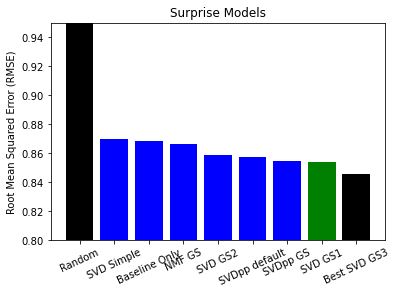

In [82]:
fig, ax = plt.subplots()
plt.bar(X, y_sort, color=['black', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'green'])
plt.xticks(rotation=25)
plt.ylim(0.8, 0.95)
plt.grid(False)
ax.set_title("Surprise Models")
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.savefig('images/suprise_models_bar.png', dpi=300, bbox_inches='tight');

<a id='rec'></a>

## Recommendation Function

With our best model ready (which uses a tuned SVD algorithm), we can incorporate it into our recommendation system.  To build this system, we will go through a few steps which are outlined below:
- build our full trainset and fit our best model on it
- we will create a subset dataframe with only unique movie IDs.  This will allow us to return 5 recommended movies, rather than the highest-recommended movie 5 times. 
- It will also play a role in letting us remove movies that the user has *already* reviewed

In [27]:
# Building our full trainset
final_model_train = data.build_full_trainset()

In [28]:
# Fitting our best model on our full trainset
svd_3.fit(final_model_train)

### Removing already reviewed movies

In [29]:
# review of combined dataframe
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [30]:
df.shape

(100836, 6)

In [31]:
# dropping duplicate movie IDs - new dataframe is df_drop
df_drop = df.drop_duplicates('movieId')
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9724 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   movieId    9724 non-null   int64  
 1   title      9724 non-null   object 
 2   genres     9724 non-null   object 
 3   userId     9724 non-null   int64  
 4   rating     9724 non-null   float64
 5   timestamp  9724 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 531.8+ KB


In [32]:
# setting index of new dataframe to 'movieId'
df_reset = df_drop.set_index('movieId')
df_reset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9724 entries, 1 to 193609
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      9724 non-null   object 
 1   genres     9724 non-null   object 
 2   userId     9724 non-null   int64  
 3   rating     9724 non-null   float64
 4   timestamp  9724 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 455.8+ KB


In [33]:
df_reset.shape

(9724, 5)

In [34]:
# create a dataframe of only user IDs and movie IDs, with index set to 'userId'
df_user = df.set_index('userId')
df_user.drop(columns=['title', 'genres', 'rating', 'timestamp'], inplace=True)
df_user.head()

,movieId
userId,
1,1
5,1
7,1
15,1
17,1


In [35]:
df_user.shape

(100836, 1)

In [36]:
# testing user input function.  n_recs won't be necessary as we were tasked with the top 5 only
user = int(input('UserId: '))
n_recs = int(input('How many recommendations? '))

UserId: 24
How many recommendations? 5


### Creating a list of already-reviewed movies

In [37]:
# creating a 'have_reviewed' list for function, based on 'userId' entered
have_reviewed = list(df_user.loc[user, 'movieId'])

In [38]:
# creating a 'not_reviewed' dataframe that has removed movies that 'user' has already seen
not_reviewed = df_reset.copy()
not_reviewed.drop(have_reviewed, inplace=True)
not_reviewed.reset_index(inplace=True)
not_reviewed.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,2,Jumanji (1995),Adventure|Children|Fantasy,6,4.0,845553522
2,3,Grumpier Old Men (1995),Comedy|Romance,1,4.0,964981247
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,6,3.0,845554349
4,5,Father of the Bride Part II (1995),Comedy,6,5.0,845553938


In [39]:
# confirming the shape of not_reviewed is less than the unique movie dataframe (9,742)
not_reviewed.shape

(9614, 6)

### Initial test for model

In [40]:
# using our best model to make predictions based on 'userId' provided above
# (creates a 'predicted_rating' column)  and returning top 5 (n_recs)

not_reviewed['predicted_rating'] = not_reviewed['movieId'].apply(lambda x: svd_3.predict(user, x).est)
not_reviewed.sort_values(by='predicted_rating', ascending=False, inplace=True)
not_reviewed.head(n_recs)

,movieId,title,genres,userId,rating,timestamp,predicted_rating
4322,6442,Belle époque (1992),Comedy|Romance,414,5.0,1055265907,4.593466
4521,6818,Come and See (Idi i smotri) (1985),Drama|War,305,5.0,1516132019,4.510438
5128,8477,"Jetée, La (1962)",Romance|Sci-Fi,567,5.0,1525282230,4.505823
9386,171495,Cosmos,(no genres listed),318,5.0,1516826406,4.493466
7253,78836,Enter the Void (2009),Drama,318,5.0,1447159301,4.476562


In [41]:
# How many unique users are there?
df['userId'].nunique()

610

In [42]:
# What's the highest userId?
df['userId'].max()

# so no skipped numbers from 1 to 610, but function below won't work above 610

610

### Complete function for movie recommendation system

Now let's put all the above steps into a unified function:

In [43]:
# thanks to Daniel for the guidance on this one

def user_recommended_movies():
    
    # input a userId
    user = int(input('Please enter a User Id (from 1 to 610): '))
    # define number of recommendations as 'Top 5'
    n_recs = 5  # could use this for user-specified recs: int(input('How many recommendations? '))
    
    # creating our have_reviewed list from the dataframe with only userId and movieId, and .loc
    have_reviewed = list(df_user.loc[user, 'movieId'])
    
    # then creating not_reviewed dataframe, removing have_reviewed from above
    not_reviewed = df_reset.copy()
    not_reviewed.drop(have_reviewed, inplace=True)
    # reset index
    not_reviewed.reset_index(inplace=True)
    # create a new column with results of lambda function with best model
    not_reviewed['predicted_rating'] = not_reviewed['movieId'].apply(lambda x: svd_3.predict(user, x).est)
    # sorting values, and will only return top 5 at the bottom
    not_reviewed.sort_values(by='predicted_rating', ascending=False, inplace=True)
    # cleaning up column names
    not_reviewed.rename(columns={'movieId':'Movie ID', 'title':'Movie Title',
                               'genres':'Genres', 'predicted_rating':'Predicted Rating'}, inplace=True)
    # dropping unnecessary columns
    not_reviewed.drop(columns=['userId', 'rating', 'timestamp'], inplace=True)
    
    print('\n' + f'Here are the top 5 recommendations for user #{user}' + '\n')
    return not_reviewed.head(n_recs)

In [44]:
# Test number 1
# user_recommended_movies()

Please enter a User Id (from 1 to 610): 610

Here are the top 5 recommendations for user #610



,Movie ID,Movie Title,Genres,Predicted Rating
4129,6818,Come and See (Idi i smotri) (1985),Drama|War,4.944254
7599,132333,Seve (2014),Documentary|Drama,4.942065
4679,8477,"Jetée, La (1962)",Romance|Sci-Fi,4.932173
3953,6442,Belle époque (1992),Comedy|Romance,4.893592
5052,27156,Neon Genesis Evangelion: The End of Evangelion...,Action|Animation|Drama|Fantasy|Sci-Fi,4.807154


In [45]:
# compare to user #610's ACTUAL ratings...
df.loc[df['userId'] == 610]

,movieId,title,genres,userId,rating,timestamp
214,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,610,5.0,1479542900
534,6,Heat (1995),Action|Crime|Thriller,610,5.0,1493850345
954,16,Casino (1995),Crime|Drama,610,4.5,1479542171
1678,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,610,4.5,1479543331
2309,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,610,5.0,1479545853
...,...,...,...,...,...,...
100232,166534,Split (2017),Drama|Horror|Thriller,610,4.0,1493848402
100294,168248,John Wick: Chapter Two (2017),Action|Crime|Thriller,610,5.0,1493850091
100309,168250,Get Out (2017),Horror,610,5.0,1494273047
100334,168252,Logan (2017),Action|Sci-Fi,610,5.0,1493846352


In [46]:
# what is the user's average rating?
df_610 = df.loc[df['userId'] == 610]
df_610['rating'].mean()

3.6885560675883258

In [47]:
len(df_610)

1302

In [48]:
# review of average user rating for the whole dataset
df['rating'].mean()

3.501556983616962

This user has rated 1302 movies across many genres.  They also have an average rating (3.69) close to the average rating for the whole dataset (3.50).  Our recommendation system returned 5 recommendations well above that user's average, indicating these 5 recommendations should be well-rated by the user.  

In [49]:
# Test number 2
# user_recommended_movies()

Please enter a User Id (from 1 to 610): 8

Here are the top 5 recommendations for user #8



,Movie ID,Movie Title,Genres,Predicted Rating
3268,4495,Crossing Delancey (1988),Comedy|Romance,4.779984
4337,6442,Belle époque (1992),Comedy|Romance,4.725032
2546,3473,Jonah Who Will Be 25 in the Year 2000 (Jonas q...,Comedy,4.655334
5017,7982,"Tale of Two Sisters, A (Janghwa, Hongryeon) (2...",Drama|Horror|Mystery|Thriller,4.648322
7300,78836,Enter the Void (2009),Drama,4.642601


In [50]:
df.loc[df['userId'] == 8]

,movieId,title,genres,userId,rating,timestamp
216,2,Jumanji (1995),Adventure|Children|Fantasy,8,4.0,839463806
614,10,GoldenEye (1995),Action|Adventure|Thriller,8,2.0,839463509
746,11,"American President, The (1995)",Comedy|Drama|Romance,8,4.0,839463806
1148,21,Get Shorty (1995),Comedy|Crime|Thriller,8,4.0,839463564
1504,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,8,3.0,839463624
1681,34,Babe (1995),Children|Drama,8,5.0,839463546
1879,39,Clueless (1995),Comedy|Romance,8,3.0,839463644
2110,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,8,4.0,839463546
2383,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,8,5.0,839463644
3390,110,Braveheart (1995),Action|Drama|War,8,3.0,839463527


In [51]:
df_8 = df.loc[df['userId'] == 8]
df_8['rating'].mean()

3.574468085106383

In [52]:
len(df_8)

47

This user had a smaller number of reviews (47) compared to user 610, but their average (3.57) again comes very close to the average user rating for the whole dataset.  

### Finding a random user for demo in slide presentation

In [248]:
# will pick the number randomly from 1 to 610
# num1 = random.randint(1, 610)
# num1

358

In [250]:
# user_recommended_movies()

Please enter a User Id (from 1 to 610): 358

Here are the top 5 recommendations for user #358



,Movie ID,Movie Title,Genres,Predicted Rating
2570,3451,Guess Who's Coming to Dinner (1967),Drama,4.693780
8780,132333,Seve (2014),Documentary|Drama,4.664560
5400,25906,Mr. Skeffington (1944),Drama|Romance,4.651805
3835,5416,Cherish (2002),Comedy|Drama|Thriller,4.578488
7311,78836,Enter the Void (2009),Drama,4.570450


In [254]:
df_358 = df.loc[df['userId'] == 358]
len(df_358)

# 41 total ratings

41

In [252]:
# top 10 rated movies
df_358.sort_values(by = ['rating'], ascending=False)[:10]

,movieId,title,genres,userId,rating,timestamp
81716,42728,Tristan & Isolde (2006),Drama|Romance,358,5.0,1339546228
35071,1721,Titanic (1997),Drama|Romance,358,5.0,1339546519
85776,55052,Atonement (2007),Drama|Romance|War,358,5.0,1339546102
65635,5066,"Walk to Remember, A (2002)",Drama|Romance,358,5.0,1339546521
89940,70599,"Time Traveler's Wife, The (2009)",Drama|Romance|Sci-Fi,358,4.5,1339546465
83188,47610,"Illusionist, The (2006)",Drama|Fantasy|Mystery|Romance,358,4.5,1339546220
89706,69757,(500) Days of Summer (2009),Comedy|Drama|Romance,358,4.5,1339546356
76360,8533,"Notebook, The (2004)",Drama|Romance,358,4.5,1339546364
74704,7361,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,358,4.0,1339546298
84761,52328,Sunshine (2007),Adventure|Drama|Sci-Fi|Thriller,358,4.0,1339546154


In [253]:
# their average rating
df_358['rating'].mean()

3.2560975609756095

## Limitations and Recommendations

One potential issue with any recommendation system based solely on user ratings is the quality of the user input.  For example, if a user rates all the movies they see very highly (e.g. 4.5 to 5.0), then the recommendation system will tend to recommend almost all the titles available, as the user would be expected to rate them all highly.  Conversely, if a user rates all the movies they see very lowly (e.g. 0.5 to 1.0) then the recommendation system may struggle to return meangingful recommendations as it has minimal information to differentiate a title the user may truly enjoy.  We would recommend more granularity to the user input in the dataset, perhaps encouraging a broader scale for user ratings (e.g. 0 to 10).  

Another potential issue to consider is the fact that a model-based collaborative filtering system depends on explicit user input to provide recommendations.  How does it handle new users?  There is no prior rating information to draw on.  Many of these systems deal with this so-called "cold start" issue by asking the user to input some favorite movie titles or movie genres right from the start.  That way, the system can at least return movies that are rated similar to that title, or fall in the same genre.  

To address the cold start problem, we will create a content-based filter below.

<a id='content'></a>

## Content-based filtering

In [53]:
# a review of how data is stored in 'genres' column: pipe-separated strings
df['genres'][3]

'Adventure|Animation|Children|Comedy|Fantasy'

We will need the dataframe with unique movie IDs again for this process.  Let's review what that dataframe looks like

In [54]:
# unique movies dataframe

df_reset.head()

,title,genres,userId,rating,timestamp
movieId,,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
2,Jumanji (1995),Adventure|Children|Fantasy,6,4.0,845553522
3,Grumpier Old Men (1995),Comedy|Romance,1,4.0,964981247
4,Waiting to Exhale (1995),Comedy|Drama|Romance,6,3.0,845554349
5,Father of the Bride Part II (1995),Comedy,6,5.0,845553938


In [55]:
df_reset.shape

(9724, 5)

In [56]:
# we'll make a copy of df_reset for the next step

df_prep = df_reset.copy()

### Cleaning strings in 'genres'

In [57]:
# function to remove pipes and split strings in the 'genres' colum, 
# creating new column of separated strings in 

def single_genres(series):
    df_prep['single_genres'] = series.str.replace('|', ' ')
    return df_prep.head()

In [58]:
# running function on 'genres' 
single_genres(df_prep['genres'])

,title,genres,userId,rating,timestamp,single_genres
movieId,,,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,Adventure Animation Children Comedy Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy,6,4.0,845553522,Adventure Children Fantasy
3,Grumpier Old Men (1995),Comedy|Romance,1,4.0,964981247,Comedy Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance,6,3.0,845554349,Comedy Drama Romance
5,Father of the Bride Part II (1995),Comedy,6,5.0,845553938,Comedy


In [59]:
# now with added column, same length as unique movie dataframe
df_prep.shape

(9724, 6)

### Creating dataframe for cosine similarity

In [118]:
# dropping redundant genres column, and columns not needed for cosine similarity

df_subset = df_prep.drop(columns=['genres', 'userId', 'rating', 'timestamp'])
df_subset.head()

,title,single_genres
movieId,,
1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
2,Jumanji (1995),Adventure Children Fantasy
3,Grumpier Old Men (1995),Comedy Romance
4,Waiting to Exhale (1995),Comedy Drama Romance
5,Father of the Bride Part II (1995),Comedy


In [120]:
df_subset.shape

(9724, 2)

### Performing TF-IDF Vectorizer

In [122]:
# dataframe of only single genres with movieId for index

df_tfidf = df_subset['single_genres']
df_tfidf.head()

movieId
1    Adventure Animation Children Comedy Fantasy
2                     Adventure Children Fantasy
3                                 Comedy Romance
4                           Comedy Drama Romance
5                                         Comedy
Name: single_genres, dtype: object

In [63]:
# instantiate TF-IDF vectorizer
tf = TfidfVectorizer()

In [123]:
# fit and transform on 'single_genres' column
tfidf_matrix = tf.fit_transform(df_tfidf)

In [65]:
# dtm = pd.DataFrame(dtm.todense(), columns=tf.get_feature_names_out(), index=df_b_r.index)

In [124]:
# create dataframe of dense matrix, prior to cosine similarity 
dense_df = pd.DataFrame(tfidf_matrix.todense(), columns=tf.get_feature_names())
dense_df.columns

Index(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres', 'horror',
       'imax', 'listed', 'musical', 'mystery', 'no', 'noir', 'romance', 'sci',
       'thriller', 'war', 'western'],
      dtype='object')

In [67]:
dense_df.head()

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,fi,...,listed,musical,mystery,no,noir,romance,sci,thriller,war,western
0,0.0,0.416817,0.51634,0.504733,0.267517,0.0,0.0,0.000000,0.483048,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.512358,0.00000,0.620425,0.000000,0.0,0.0,0.000000,0.593769,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.00000,0.000000,0.570532,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.821275,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.00000,0.000000,0.504636,0.0,0.0,0.466539,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.726418,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.00000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [131]:
# remove columns with no genre listed ('no', 'genres') as well as 'fi' since that duplicates 'sci'
dense_df.drop(columns=['no', 'genres', 'fi'], inplace=True)

In [132]:
dense_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9724 entries, 0 to 9723
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   action       9724 non-null   float64
 1   adventure    9724 non-null   float64
 2   animation    9724 non-null   float64
 3   children     9724 non-null   float64
 4   comedy       9724 non-null   float64
 5   crime        9724 non-null   float64
 6   documentary  9724 non-null   float64
 7   drama        9724 non-null   float64
 8   fantasy      9724 non-null   float64
 9   film         9724 non-null   float64
 10  horror       9724 non-null   float64
 11  imax         9724 non-null   float64
 12  listed       9724 non-null   float64
 13  musical      9724 non-null   float64
 14  mystery      9724 non-null   float64
 15  noir         9724 non-null   float64
 16  romance      9724 non-null   float64
 17  sci          9724 non-null   float64
 18  thriller     9724 non-null   float64
 19  war   

### Cosine similarity

In [125]:
# instantiating Cosine Similarity on our dense dataframe: dense_df
cosine_sim = cosine_similarity(dense_df)

In [128]:
# sample row, illustrating similarity (0-1) of the 1st movie entry relative to all other movies
cosine_sim[0]

array([1.        , 0.81352752, 0.15262722, ..., 0.        , 0.42122062,
       0.26751731])

In [199]:
# creating dataframe from cosine similarity matrix, indexed on dense_df
df_cos = pd.DataFrame(data=cosine_sim)
df_cos

# note 9724 x 9724 matrix for all remaining unique movies

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,1.000000,0.813528,0.152627,0.134999,0.267517,0.000000,0.152627,0.654593,0.000000,0.262372,...,0.360537,0.465676,0.196433,0.516340,0.0,0.680408,0.755981,0.000000,0.421221,0.267517
1,0.813528,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.804635,0.000000,0.322512,...,0.000000,0.000000,0.000000,0.000000,0.0,0.341472,0.379399,0.000000,0.000000,0.000000
2,0.152627,0.000000,1.000000,0.884500,0.570532,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.162721,0.000000,0.418930,0.000000,0.0,0.181710,0.201893,0.000000,0.000000,0.570532
3,0.134999,0.000000,0.884500,1.000000,0.504636,0.000000,0.884500,0.000000,0.000000,0.000000,...,0.143927,0.201540,0.687253,0.000000,0.0,0.160723,0.178574,0.466539,0.000000,0.504636
4,0.267517,0.000000,0.570532,0.504636,1.000000,0.000000,0.570532,0.000000,0.000000,0.000000,...,0.285209,0.000000,0.734280,0.000000,0.0,0.318492,0.353868,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.680408,0.341472,0.181710,0.160723,0.318492,0.239252,0.181710,0.000000,0.435822,0.240934,...,0.599328,0.554410,0.233863,0.614729,0.0,1.000000,0.900033,0.000000,0.753546,0.318492
9720,0.755981,0.379399,0.201893,0.178574,0.353868,0.000000,0.201893,0.000000,0.000000,0.000000,...,0.476912,0.615989,0.259838,0.683007,0.0,0.900033,1.000000,0.000000,0.557184,0.353868
9721,0.000000,0.000000,0.000000,0.466539,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.431990,0.678847,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000
9722,0.421221,0.000000,0.000000,0.000000,0.000000,0.317501,0.000000,0.000000,0.578361,0.319733,...,0.674798,0.735735,0.000000,0.815781,0.0,0.753546,0.557184,0.000000,1.000000,0.000000


### Creating parts for function

In [230]:
movie_title = input('Provide your favorite movie title from the dataset: ')

Provide your favorite movie title from the dataset: Jumanji (1995)


In [233]:
movie_idx_1 = df_subset.index[df_subset['title'] == movie_title].tolist()
movie_idx_1

[2]

In [236]:
# the above index value is off by 1, and it's in a list, so...
movie_idx_2 = movie_idx_1[0] - 1
movie_idx_2

1

### Creating dataframe for recommendations

In [237]:
recs_df = df_cos.sort_values(by=[1], ascending=False)[0:5]
recs_df

# note all the '1.0' in the '1' column, indicating exact genre matches

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
1617,0.813528,1.0,0.0,0.0,0.0,0.0,0.0,0.804635,0.0,0.322512,...,0.0,0.0,0.0,0.0,0.0,0.341472,0.379399,0.0,0.0,0.0
53,0.813528,1.0,0.0,0.0,0.0,0.0,0.0,0.804635,0.0,0.322512,...,0.0,0.0,0.0,0.0,0.0,0.341472,0.379399,0.0,0.0,0.0
1616,0.813528,1.0,0.0,0.0,0.0,0.0,0.0,0.804635,0.0,0.322512,...,0.0,0.0,0.0,0.0,0.0,0.341472,0.379399,0.0,0.0,0.0
109,0.813528,1.0,0.0,0.0,0.0,0.0,0.0,0.804635,0.0,0.322512,...,0.0,0.0,0.0,0.0,0.0,0.341472,0.379399,0.0,0.0,0.0
1798,0.813528,1.0,0.0,0.0,0.0,0.0,0.0,0.804635,0.0,0.322512,...,0.0,0.0,0.0,0.0,0.0,0.341472,0.379399,0.0,0.0,0.0


In [238]:
# pulling out individual index numbers from total recs_list
recs_list = recs_df.index.tolist()
recs_list[0]

1617

In [239]:
# Compiling the above code into a working function that takes 
# an exact movie title as input and returns 5 recommendations

def content_based():
    
    movie_title = input('Provide your favorite movie title from the dataset: ')
    movie_idx_1 = df_subset.index[df_subset['title'] == movie_title].tolist()
    movie_idx_2 = movie_idx_1[0] - 1
    
    recs_df = df_cos.sort_values(by=movie_idx_2, ascending=False)[0:5]
    recs_list = recs_df.index.tolist()
    
    movie_1 = df_subset['title'].loc[df_subset.index[recs_list[0]]]
    movie_2 = df_subset['title'].loc[df_subset.index[recs_list[1]]]
    movie_3 = df_subset['title'].loc[df_subset.index[recs_list[2]]]
    movie_4 = df_subset['title'].loc[df_subset.index[recs_list[3]]]
    movie_5 = df_subset['title'].loc[df_subset.index[recs_list[4]]]
    
    recs_message_1 = f"Your top movie recommendation is {movie_1}."
    
    recs_message_2 = f"You may also enjoy: {movie_2}, {movie_3}, {movie_4}, and {movie_5}"

    
    return recs_message_1, recs_message_2

In [240]:
# content_based()

Provide your favorite movie title from the dataset: Jumanji (1995)


('Your top movie recommendation is NeverEnding Story II: The Next Chapter, The (1990).',
 'You may also enjoy: Indian in the Cupboard, The (1995), NeverEnding Story, The (1984), NeverEnding Story III, The (1994), and Santa Claus: The Movie (1985)')

The content-based filter appears to be pretty accurate based on the return above.  We didn't test this at length

<a id='summary'></a>

# Summary

In summary, we were tasked with creating a top 5 movie recommendation system to demonstrate for the JustWatch streaming guide app.  Using the "small" dataset from MovieLens, we were able to produce a model-based collaborative filtering recommendation system that allows for user input and returns the top 5 recommendations of movies from the dataset that the user has not yet rated. We primarily used the Surprise Python scikit library to process data and iterate through multiple recommender algorithms (including SVD and SVD++), using GridSearch, cross-validation and RMSE to decide on our best-performing model. Our final model used a tuned SVD algorithm with an RMSE of 0.8457. We also created a content-based filtering model, using TF-IDF Vectorizer and cosine similarity, to address the "cold start" problem inherent in collaborative filtering models. With this model, a user who is not already in the dataset can input a known movie from the dataset and be returned 5 movie recommendations to choose from.

## Additional Citations

- __[Daniel Burdeno Kindle e-book Recommendations](https://github.com/danielburdeno/Kindle-eBook-Recommendations)__
- __[Amol Mavuduru using Surprise for Recommender System](https://github.com/AmolMavuduru/SurprisePythonExamples)__
- __[Amol Mavduru blogpost about Surprise](https://towardsdatascience.com/how-you-can-build-simple-recommender-systems-with-surprise-b0d32a8e4802)__
- __[Susan Li building recommender systems](https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b#:~:text=NormalPredictor%20algorithm%20predicts%20a%20random%20rating%20based%20on,algorithms%20that%20do%20not%20do%20much%20work.%20BaselineOnly)__
-__[James Le blog on recommender systems etc](https://le-james94.medium.com/the-4-recommendation-engines-that-can-predict-your-movie-tastes-bbec857b8223)__
- __[Surprise documentation on algorithms](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)__